## [Chapter 3](https://ccrma.stanford.edu/~jos/pasp/Artificial_Reverberation.html)
# Artificial Reverberation

For this chapter, all that's here is most of the lab. Not a lot to see here, but there is an implemenation of an order-4 SISO feedback delay network, with and without a lowpass filters on the delay lines, in the files [FDNJot4.h](https://github.com/khiner/notebooks/blob/master/physical_audio_signal_processing/cpp/FDNJot4.h) and [FDNJot4LP.h](https://github.com/khiner/notebooks/blob/master/physical_audio_signal_processing/cpp/FDNJot4LP.h).

Responses to impulse and speech inputs are provided for both below.

## Exercises

### Reververation Laboratory Exercises

**1. Write an STK module called `FDNJot4.cpp` which implements an order 4 SISO feedback delay network with $B^T = [1,1,1,1], C^T = [1,1,1,1]$, and a feedback matrix $A = A_4$, where**

$A_N \triangleq g\left(I_N - \frac{2}{N}u_Nu_N^T\right)$,

**where $I_N$ denotes the $N \times N$ identity matrix, and $u_N = [1,...,1]^T$.**

(More exercise details in the text.)

Here is the first 100 sample of an impulse response with $g = 1$ and $M = [3,5,7,11]$:

```cpp
0, 0, 0, 1, 0, 1, 0.5, 1, -1, 0.25, -0.5, 0.75, -0.875, -0.5, -0.5, 1.8125, -1.25, -0.6875, -0.96875, 1.1875, -0.0625, 1.14062, 0.53125, 1.92188, -0.554688, -0.5, -2.84375, 0.0195312, 0.0625, -0.167969, -0.591797, 1.11328, 0.839844, 1.00098, -1.18164, 1.47168, -0.659668, -0.0449219, -1.18945, 0.448486, 0.0595703, 1.6731, -1.8905, -1.15063, -0.627197, 0.815979, -0.11853, 0.829773, 1.00174, 2.28638, -1.30115, -0.167648, -0.991821, -0.0731659, -1.05578, -0.656235, -1.21144, 1.84027, 0.443901, 1.0807, -0.929335, 1.4789, -0.511482, -0.661075, -0.838505, 1.39083, 0.516984, 0.295619, -1.79552, -0.608328, -0.720294, 0.544127, -0.782937, 1.02704, 0.695086, 2.31194, -1.4192, 0.854171, 0.295708, -0.456762, -2.15872, -0.99062, -0.681779, 1.84512, -0.13935, 0.932496, -0.359248, 0.729367, -0.24348, -0.451537, -0.585074, 2.2994, -0.281669, -0.382952, -1.29751, 0.599774, -1.12285, -0.162531, -1.43737, 1.26507
```

With a value of $g = 1$, the response is overall uniform in volume over time, so this is close enough for me to "lossless" behavior. I am sticking with the four Schroeder comb filter delay lengths of $M = [1687, 1601, 2053, 2251]$, even though they were derived for a 25kHz sampling rate rather than 44.1kHz, as it sounds pretty flat after a second or so (I guess? There is a lot of regularity which concerns me, but it's kind of "white noise"-y). Here is a recording of the first 8 seconds:

Text(0, 0.5, 'Amplitude')

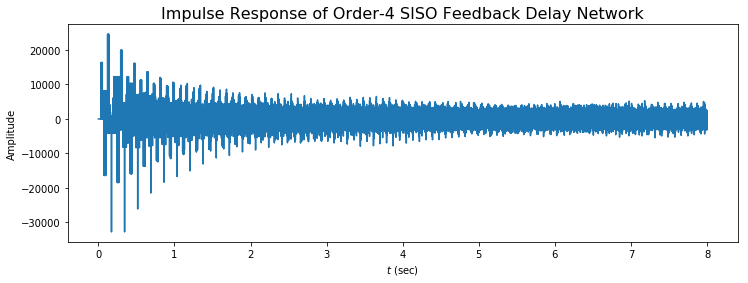

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline

fs, samples = readwav('FDNJot4IR.wav')
t = np.arange(samples.size) / fs
plt.figure(figsize=(12, 4))
plt.plot(t, samples)
plt.title('Impulse Response of Order-4 SISO Feedback Delay Network', size=16)
plt.xlabel('$t$ (sec)')
plt.ylabel('Amplitude')

In [3]:
from IPython.display import Audio
from scipy.io.wavfile import read as readwav

fs, samples = readwav('FDNJot4IR.wav')
Audio(samples, rate=fs)

Text(0.5, 6.0, 'Frequency (Hz)')

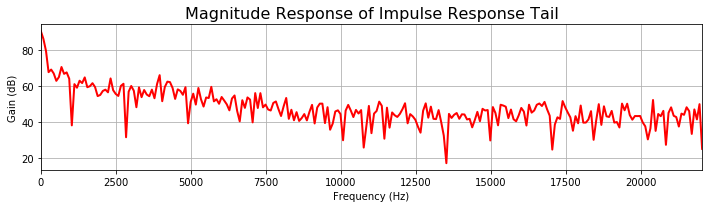

In [35]:
import sys
sys.path.append('../')
from PlotUtils import plot_frequency_response
import numpy as np

n = 512
response_tail = samples[-n:]

H = np.fft.rfft(response_tail)
w = np.fft.rfftfreq(n, d=1.0/fs)
fig, [frequency_plot, _] = plot_frequency_response(w, H, show_phase_plot=False)
frequency_plot.set_title('Magnitude Response of Impulse Response Tail', size=16)
frequency_plot.set_xlabel('Frequency (Hz)')

The frequency response above shows that it is roughly flat over the frequency spectrum, with some more low-frequency energy. For only 4 delay lines and uniform scaling everywhere, this seems close enough to me to convince me that I don't have any major bugs.

Let's hear it on some audio:

**Dry:**

In [34]:
fs, samples = readwav('speech-male.wav')
Audio(samples, rate=fs)

**Wet:**

In [9]:
fs, samples = readwav('FDNJot4IR-speech-male.wav')
Audio(samples, rate=fs)

**2. Write an STK module called `FDNJot4LP.cpp` in which each of the four delay lines is cascaded with a one-pole lowpass filter**

$H_i(z) = g_i\frac{1-a_i}{1-a_iz^{-1}}, i = 1,2,3,4$,

**where $g_i$ and $a_i$ are automatically computed using Jot's formulas. The inputs to Jot's formulas are the desired reverberation time at dc and at half the sampling rate.**

Here's my port of the Jot equations on p118:
```cpp
    static stk::StkFloat calculateFilterGain(const stk::StkFloat t60DC, const unsigned long delaySamples) {
        return pow(10, -3 * (stk::StkFloat(delaySamples) / stk::StkFloat(Stk::sampleRate())) / t60DC);
    }

    static stk::StkFloat calculateFilterPole(stk::StkFloat g, stk::StkFloat t60DC, stk::StkFloat t60HalfSamplingRate) {
        return (log(10) / 4.0) * log10(g) * (1.0 - (1.0 / pow(t60HalfSamplingRate / t60DC, 2)));
    }
```

And here's an impulse response with `t60DC = 5` and `t60HalfSamplingRate = 8`:

In [18]:
fs, samples = readwav('FDNJot4LPIR.wav')
Audio(samples, rate=fs)

In [8]:
fs, samples = readwav('FDNJot4LPIR-speech-male.wav')
Audio(samples, rate=fs)

### EDC/EDR Laboratory Exercise

**1. Plot the energy decay curve (EDC) and Energy Decay Relief (EDR) of the Jot reverberator you built in the previous assignment.**

TODO

_Skipping the rest of the exercises for now and focusing on implementations in later chapters._

For examples of using an energy decay relief plot to estimate parameters for a loop filter, see [part 2 of Chapter 9](https://colab.research.google.com/github/khiner/notebooks/blob/master/physical_audio_signal_processing/chapter_9_virtual_musical_instruments_part_2.ipynb).